In [29]:
import logging

from utils import logging as lg


lg.set_logging(logging.ERROR)

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cmocean


tf.logging.set_verbosity(tf.logging.ERROR)

import math

from utils import data_provider
from utils import experiment_artifact
from notebook_utils import plot
from model import s2_network, s3_network, deep_4l_network, convdeep_4l_network, provider as model_provider

from heatmap_tutorial import modules, utils
import matplotlib.gridspec as gridspec

plot.setup()


# Data Preparation

In [3]:
dataset = {
    'mnist': data_provider.MNISTData(dir_path='../data/mnist'),
    'fashion-mnist': data_provider.FashionMNISTData(dir_path='../data/fashion-mnist')
}

## Model

In [4]:
models = {
    'seq-4': {
        's2': '../experiment-results/sprint-8-final/s2-mnist-seq-4---2017-12-13--14-02-34',
#         's2_no_do_rr': '../experiment-results/sprint-8-no-dropout-rr/s2-seq-4---2017-12-08--21-13-04',
#         's2_updated': '../experiment-results/sprint-8-updated/s2-seq-4---2017-12-13--13-21-25',
        's3': '../experiment-results/sprint-8-final/s3-mnist-seq-4---2017-12-13--14-28-48',
#         's3_no_do_rr': '../experiment-results/sprint-8-no-dropout-rr/s3-seq-4---2017-12-09--12-35-53',
#         's3_updated': '../experiment-results/sprint-8-updated/s3-mnist-seq-4---2017-12-13--13-36-56'
    },
    'seq-7': {
        's2': '../experiment-results/sprint-8-final/s2-mnist-seq-7---2017-12-13--14-13-10',
#         's2_no_do_rr': '../experiment-results/sprint-8-no-dropout-rr/s2-seq-7---2017-12-08--22-02-57',
#         's2_updated': '../experiment-results/sprint-8-updated/s2-seq-7---2017-12-13--13-27-37',
        's3': '../experiment-results/sprint-8-final/s3-mnist-seq-7---2017-12-13--17-23-19',
#         's3_no_do_rr': '../experiment-results/sprint-8-no-dropout-rr/s3-seq-7---2017-12-09--23-36-28',
        's3_updated': '../experiment-results/sprint-8-updated/s3-mnist-seq-7---2017-12-13--13-46-22'
    },
    'seq-14': {
        's2': '',
        's3': ''
    }
}

# Visualize Weights

2017-12-19 23:14:13,632 | INFO : provider.py(load 14) - ExperimentArtifact(accuracy=0.9779000282287598, architecture='hidden:256|out:10--recur:256', batch=50, column_at_a_time=7, dims=28, epoch=100, experiment_name='s2-mnist-seq-4---2017-12-13--14-02-34', lr=0.0005, max_seq_length=28, seq_length=4, path='../experiment-results/sprint-8-final/s2-mnist-seq-4---2017-12-13--14-02-34', architecture_name='s2_network', val_accuracy=0.9783333539962769, keep_prob=0.5, optimizer='AdamOptimizer', dataset='mnist', regularizer=0.0)


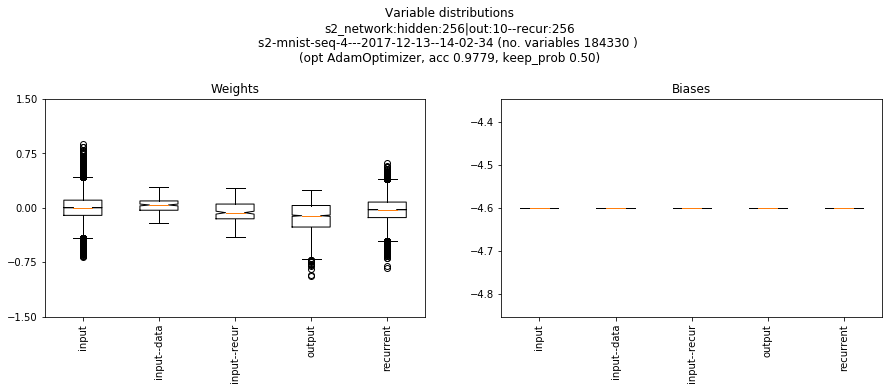

In [5]:
from utils import network_architecture

def plot_weight_bias(model_path):
    model_obj = model_provider.load(model_path)
    weights, bias = model_obj.get_weight_bias_at_layers()
    ws = []
    bs = []
    keys = []

    plt.figure(figsize=(15,4))
    for k in sorted(weights.keys()): 
            w = weights[k].reshape(-1,1)
            b = bias[k].reshape(-1,1)
            ws.append(w)
            bs.append(b)
            
            keys.append(k)
            if (model_obj._.architecture_name == 's2_network' and k == 'input') or (model_obj._.architecture_name == 's3_network' and k == 'input_to_cell') :
                rr_units = network_architecture.parse(model_obj._.architecture)['recur']
                ws.append(w[:rr_units,:])
                bs.append(b[:rr_units,:])
                keys.append('%s--data' % k )
                
                ws.append(w[-rr_units:,:])
                bs.append(b[-rr_units:,:])
                keys.append('%s--recur' % k )
    plt.suptitle('Variable distributions\n%s:%s\n%s (no. variables %d ) \n(opt %s, acc %.4f, keep_prob %.2f)' %
                     (
                      model_obj._.architecture_name,
                      model_obj._.architecture,
                      model_obj._.experiment_name,
                      model_obj.dag.no_variables(),
                      model_obj._.optimizer,
                      model_obj._.accuracy,
                      model_obj._.keep_prob
                     ), y = 1.2)

            
    ticks = range(1, len(ws)+1)
    plt.subplot(1,2,1)
    plt.boxplot(ws, keys)
    plt.title('Weights')
    plt.yticks([-1.5,-0.75,0,0.75,1.5])
    plt.xticks(ticks, keys, rotation='vertical')

    plt.subplot(1,2,2)
    plt.boxplot(bs, keys)
    plt.title('Biases')
    plt.xticks(ticks, keys, rotation='vertical')
    plt.show()
    
plot_weight_bias(models['seq-4']['s2'])

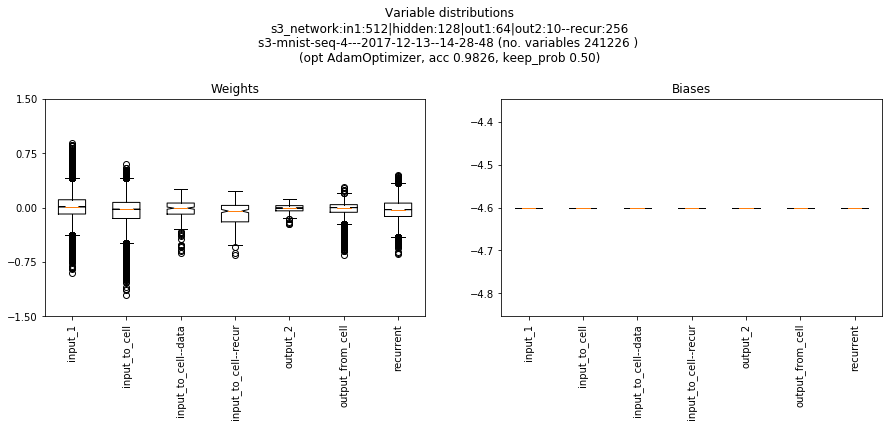

In [8]:
plot_weight_bias(models['seq-4']['s3'])

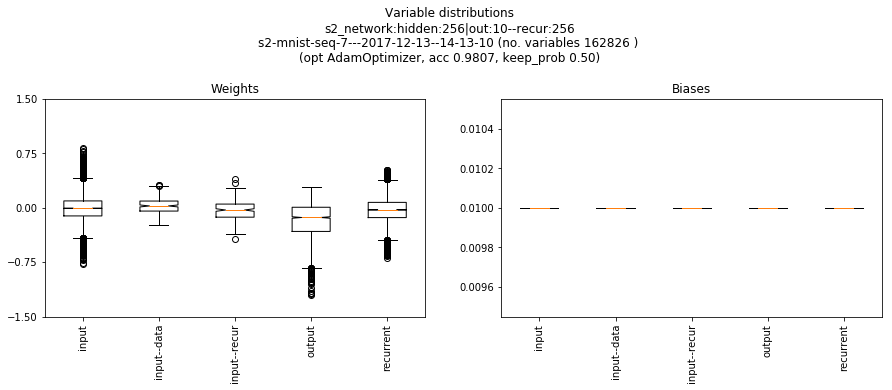

In [7]:
plot_weight_bias(models['seq-7']['s2'])

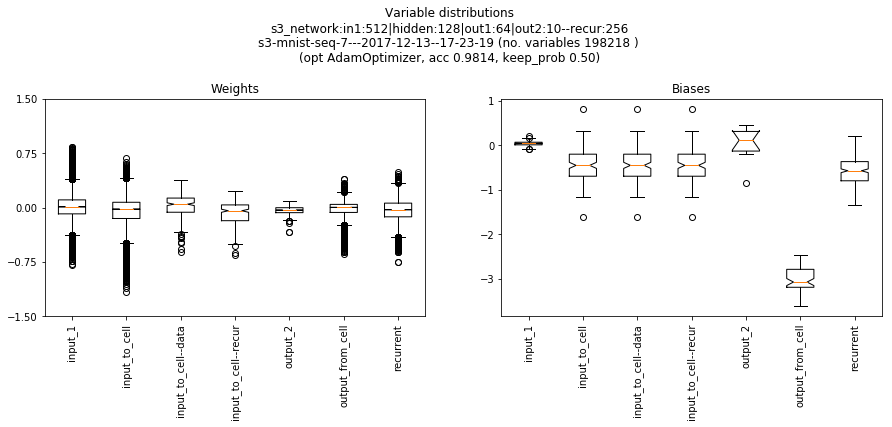

In [129]:
plot_weight_bias(models['seq-7']['s3'])

# Visualize Relevance

In [6]:
def get_test_data_in_class(ds, label):
    x, y = dataset[ds].test2d.x, dataset[ds].test.y
    if label is None:
        return x, y
    selector = np.argmax(y, axis=1) == label

    return x[selector, :, :], y[selector]

def plot_digits(data, limit=200):
    plt.figure(figsize=(20,20))
    count = 1
    for i in range(limit):
        plt.subplot(10,20, count)
        plt.imshow(data[i,:].reshape(28,28))
        plt.xticks([])
        plt.yticks([])
        plt.title(i)
        count = count + 1
    plt.tight_layout()
    plt.show()

def rel_dist_deep_taylor(model_obj, data):
    
    _, heatmap = model_obj.lrp(data, debug=False)

    relevance_dist = np.sum(heatmap.transpose(2,1,0).reshape(model_obj._.seq_length,-1),axis=1)

    return relevance_dist, heatmap

def plot_lrp_relevance_dist_all(model_obj):
    fig = plt.figure(figsize=(15,7.5))
    
    rel_dists = []


    for i in [None] + list(range(0,10)):
        x, _ = get_test_data_in_class(model_obj._.dataset, i)
        rel_dist_dt, _ = rel_dist_deep_taylor(model_obj, x)
        rel_dists.append(rel_dist_dt)

        
    data_obj = dataset[model_obj._.dataset]
    labels = ['All Test Data'] + list(map(lambda x: data_obj.get_text_label(x), range(0,10)))
    x_ticks = np.arange(model_obj._.seq_length) + 1
    
    plt.suptitle('Relevance distribution from LRP Deep Taylor\n model: %s\n%s(acc %.4f)' %
             (
                 model_obj._.experiment_name,
                 model_obj._.architecture,
                 model_obj._.accuracy,
             ),
            )
    
    for i, r in zip(range(len(rel_dists)), rel_dists):
        if i == 0:
            ax = plt.subplot2grid((4, 3), (0, 0), rowspan=2)
        else:
            row_id = int(i/3)
            col_id = i%3
            if row_id >= 1:
                col_id = col_id + 1
                if col_id >= 3:
                    row_id = row_id+1
                    col_id = (col_id)%3
            ax = plt.subplot2grid((4, 3), (row_id, col_id))
    #         print('%d and (%d,%d)' % (i, row_id, col_id))
    # ax0.plot()
        rel_dist = rel_dists[i]

        def plot_bar_chart(axis, data):
            axis.bar(x_ticks, data, 0.5, color='r')
            axis.set_xticks(x_ticks)
        plot_bar_chart(ax, rel_dist)

        ax2 = ax.twinx()

        if i == 0:
            ax.set_ylabel('Aggregated relevance')
            ax.set_xlabel('Step $i$-th')
            ax2.set_ylabel('Percentage')

        relative_dist = rel_dist / np.sum(rel_dist)
        plot_bar_chart(ax2, relative_dist)

        ax.set_title(labels[i])

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()
    
# plot_rel_and_dist(models['seq-4']['s2'])

In [64]:
def plot_relevance_methods(model_obj, 
                           dataset = dataset['mnist'], methods=['sensitivity', 'simple_taylor', 'lrp_deep_taylor'],
                           skip_data=False
                          ):
    data, label = dataset.get_samples_for_vis()
    total = data.shape[0]
    
    if not skip_data :
        methods = [None] + methods
    total_methods = len(methods)
    
    fig = plt.figure(figsize=(20,2*total_methods))

    outer = gridspec.GridSpec(total_methods, 1)
    
    pred_heatmaps = dict()
    actual_methods = list(filter(lambda x: x, methods))
    for method in actual_methods:
        if 'lrp_f' in method:
            factor = float(method.split('_f')[1])
            pred_heatmaps[method] = getattr(model_obj, 'lrp')(data, debug=False, factor=factor)
        else:
            pred_heatmaps[method] = getattr(model_obj, 'rel_%s' % method)(data, debug=False)

    for i in range(total_methods):
        inner = gridspec.GridSpecFromSubplotSpec(1, total,
                        subplot_spec=outer[i], wspace=0.1, hspace=0.05)
   
        method = methods[i]
            
        for j in range(total):
            ax = plt.Subplot(fig, inner[j])
            if method is not None:
                heatmap = pred_heatmaps[method][1][j,:,:]
            else:
                heatmap = data[j,:]
                pred_idx = pred_heatmaps[actual_methods[0]][0][j]
                ax.set_title('Pred\n%s(%d)' % ( dataset.get_text_label(pred_idx),pred_idx) )

            ax.imshow(heatmap, cmap="Reds")
            ax.set_xticks([])
            ax.set_yticks([])

            fig.add_subplot(ax)
        
        ax_outer = plt.Subplot(fig, outer[i])
        if method is not None:
            title = method
        else:
            title = 'data'
            
        ax_outer.set_title('\n%s\n' % title)

        ax_outer._frameon = False
        ax_outer.xaxis.set_visible(False)
        ax_outer.yaxis.set_visible(False)
        fig.add_subplot(ax_outer)

    plt.suptitle('Heatmaps from different explaination methods\n%s:%s\n%s (no. variables %d ) \n(opt %s, acc %.4f, keep_prob %.2f)' %
                         (
                          model_obj._.architecture_name,
                          model_obj._.architecture,
                          model_obj._.experiment_name,
                          model_obj.dag.no_variables(),
                          model_obj._.optimizer,
                          model_obj._.accuracy,
                          model_obj._.keep_prob
                         ), y = 1.1)
    
    plt.tight_layout()    

    plt.show()
    
def plot_rel_and_dist(m, methods=['sensitivity', 'simple_taylor', 'lrp_deep_taylor'], skip_data=False):
    model_obj = model_provider.load(m)

    plot_relevance_methods(model_obj, dataset = dataset[model_obj._.dataset], methods=methods, skip_data=skip_data )
    
    # This need to be fixed for mnist, fashion-mnist
#     plot_lrp_relevance_dist_all(model_obj)
    


## Seq 4

2017-12-20 00:53:05,814 | INFO : provider.py(load 14) - ExperimentArtifact(accuracy=0.9779000282287598, architecture='hidden:256|out:10--recur:256', batch=50, column_at_a_time=7, dims=28, epoch=100, experiment_name='s2-mnist-seq-4---2017-12-13--14-02-34', lr=0.0005, max_seq_length=28, seq_length=4, path='../experiment-results/sprint-8-final/s2-mnist-seq-4---2017-12-13--14-02-34', architecture_name='s2_network', val_accuracy=0.9783333539962769, keep_prob=0.5, optimizer='AdamOptimizer', dataset='mnist', regularizer=0.0)
2017-12-20 00:53:06,460 | INFO : base.py(compute_grad_wrt_x 75) - Compute grad wrt. X shape (12, 28, 28)
2017-12-20 00:53:07,063 | INFO : base.py(compute_grad_wrt_x 89) - Grad result in shape (12, 28, 28)
2017-12-20 00:53:07,076 | INFO : base.py(compute_grad_wrt_x 75) - Compute grad wrt. X shape (12, 28, 28)
2017-12-20 00:53:07,722 | INFO : base.py(compute_grad_wrt_x 89) - Grad result in shape (12, 28, 28)


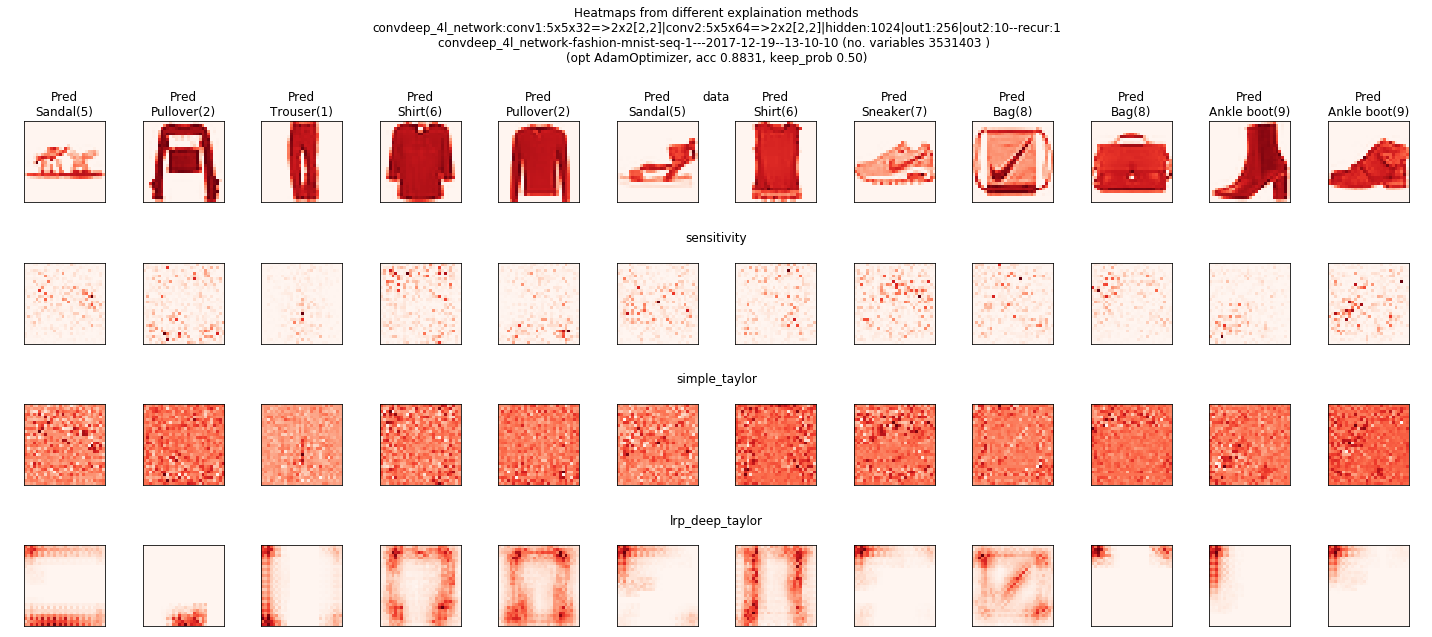

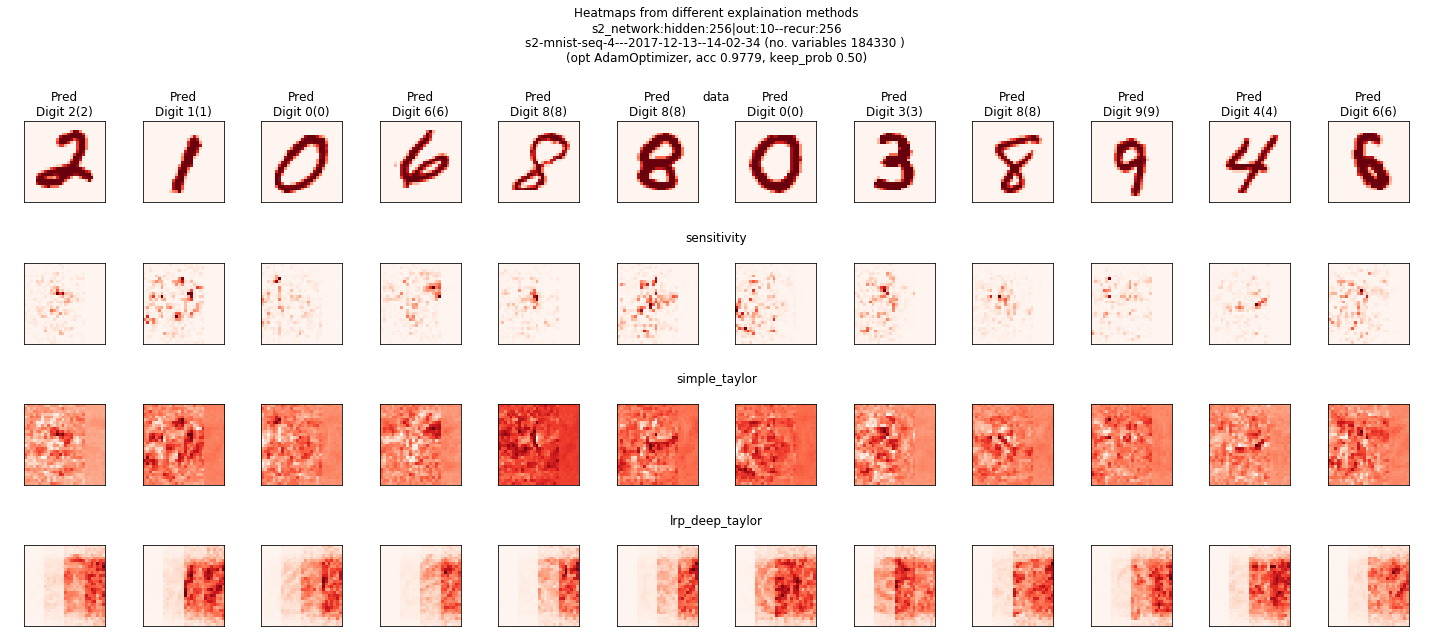

In [65]:
plot_rel_and_dist(models['seq-4']['s2'])

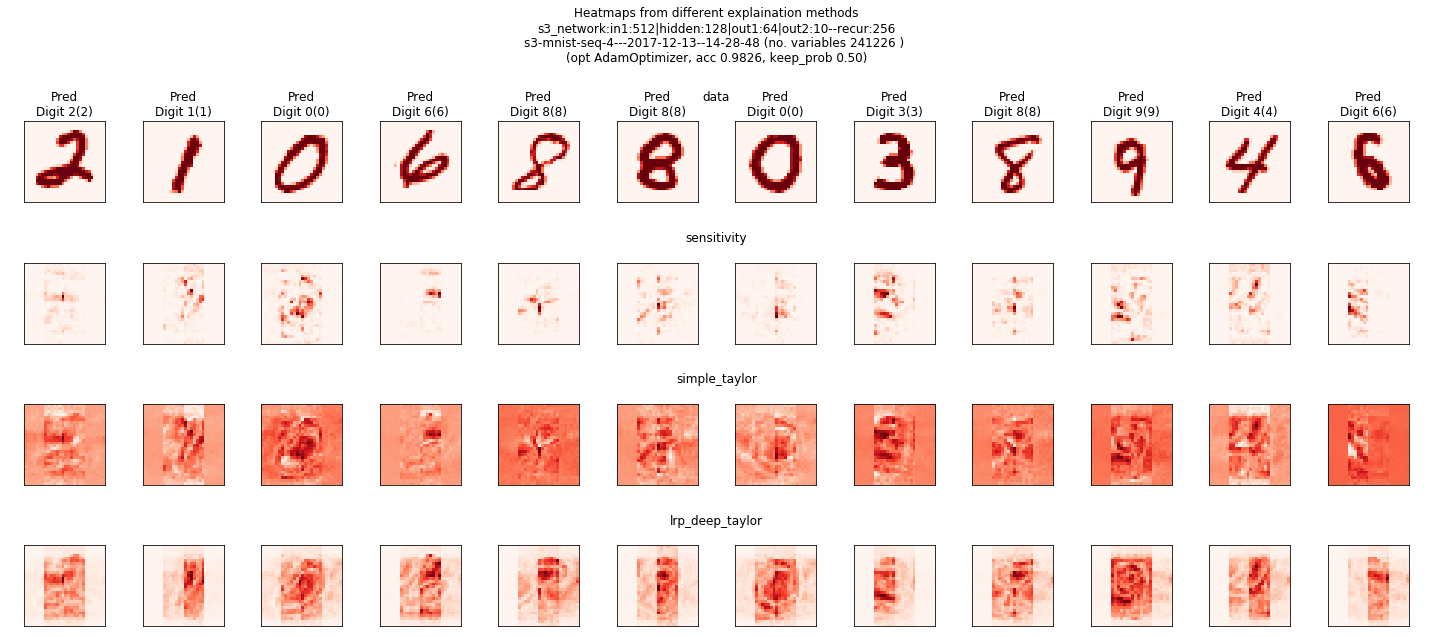

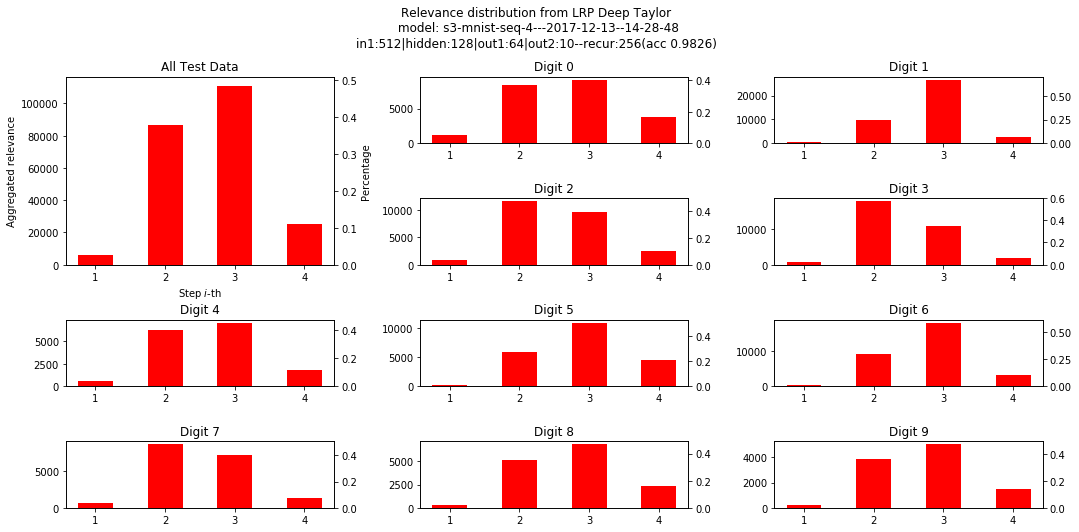

In [198]:
plot_rel_and_dist(models['seq-4']['s3'])

## Seq 7

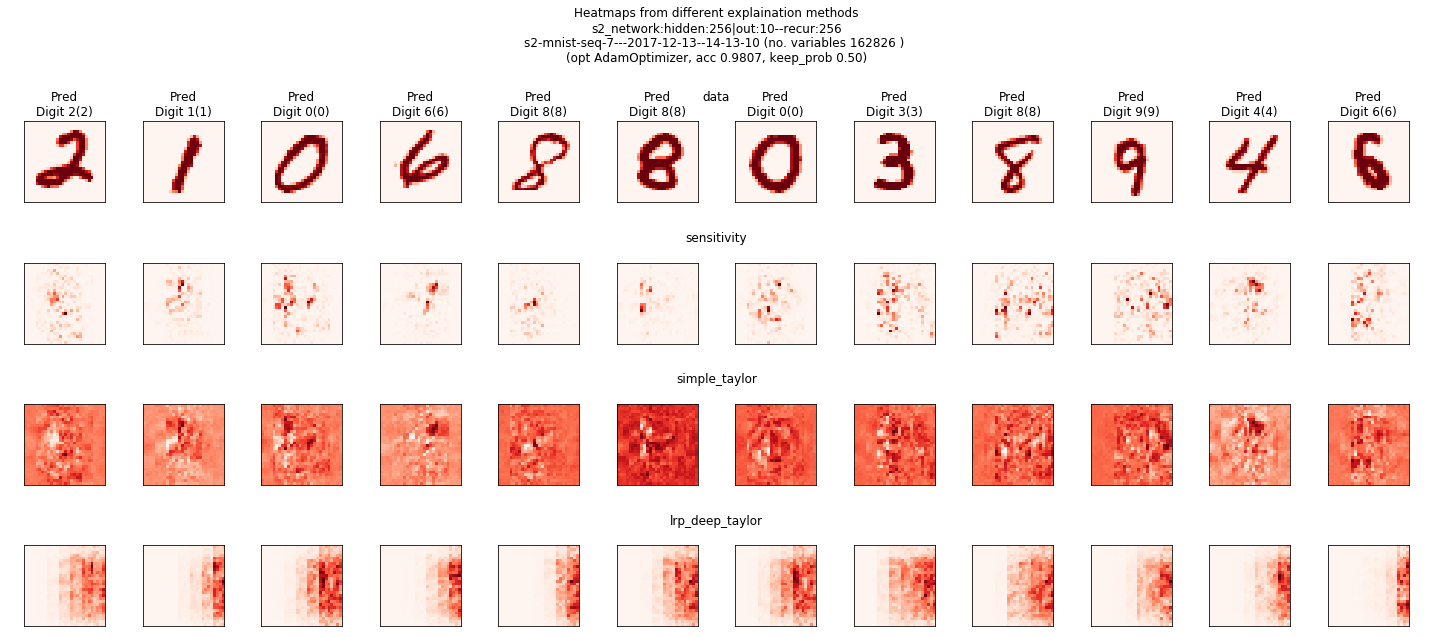

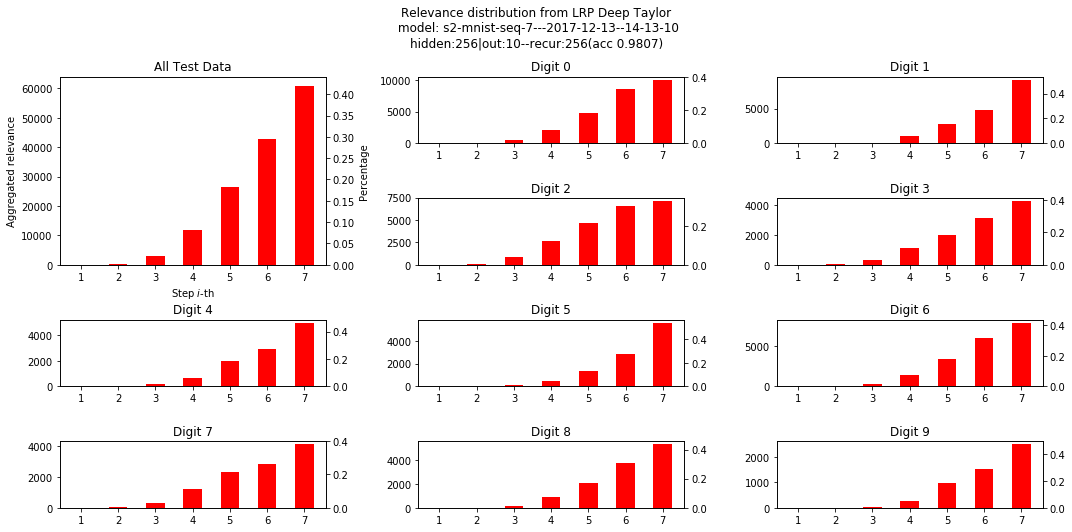

In [199]:
plot_rel_and_dist(models['seq-7']['s2'])

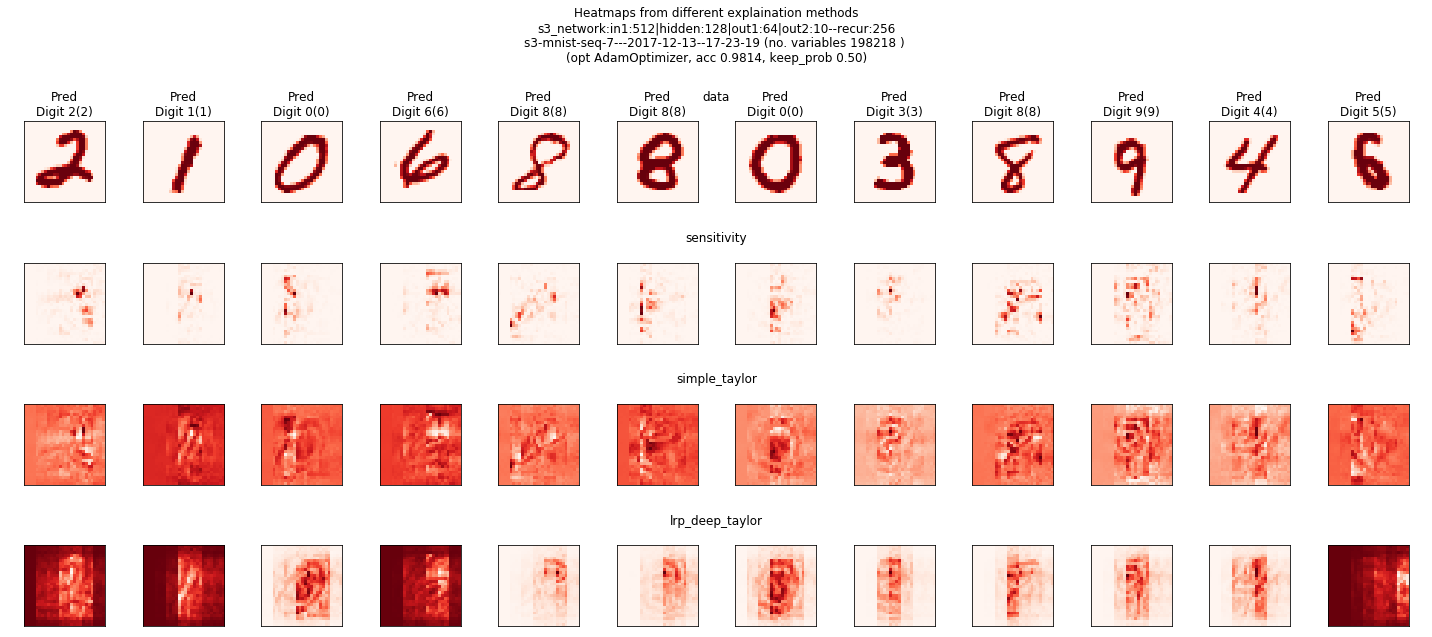

In [35]:
plot_rel_and_dist(models['seq-7']['s3'])

# FashionMNIST

In [221]:
fashion_mnist_models = {
    'seq-1': {
        's2': '../experiment-results/sprint-8-fashion-mnist-100epoch/s2-fashion-mnist-seq-1---2017-12-13--22-05-42',
        's3': '../experiment-results/sprint-8-fashion-mnist-100epoch/s3-fashion-mnist-seq-1---2017-12-13--22-37-42'
    },
    'seq-4': {
        's2': '../experiment-results/sprint-8-fashion-mnist-100epoch/s2-fashion-mnist-seq-4---2017-12-13--22-10-34',
        's3': '../experiment-results/sprint-8-fashion-mnist-100epoch/s3-fashion-mnist-seq-4---2017-12-13--22-46-52'
    },
    'seq-7': {
        's2': '../experiment-results/sprint-8-fashion-mnist-100epoch/s2-fashion-mnist-seq-7---2017-12-13--22-21-38',
        's3': '../experiment-results/sprint-8-fashion-mnist-100epoch/s3-fashion-mnist-seq-7---2017-12-13--23-07-33'
    }
}

## Seq 1

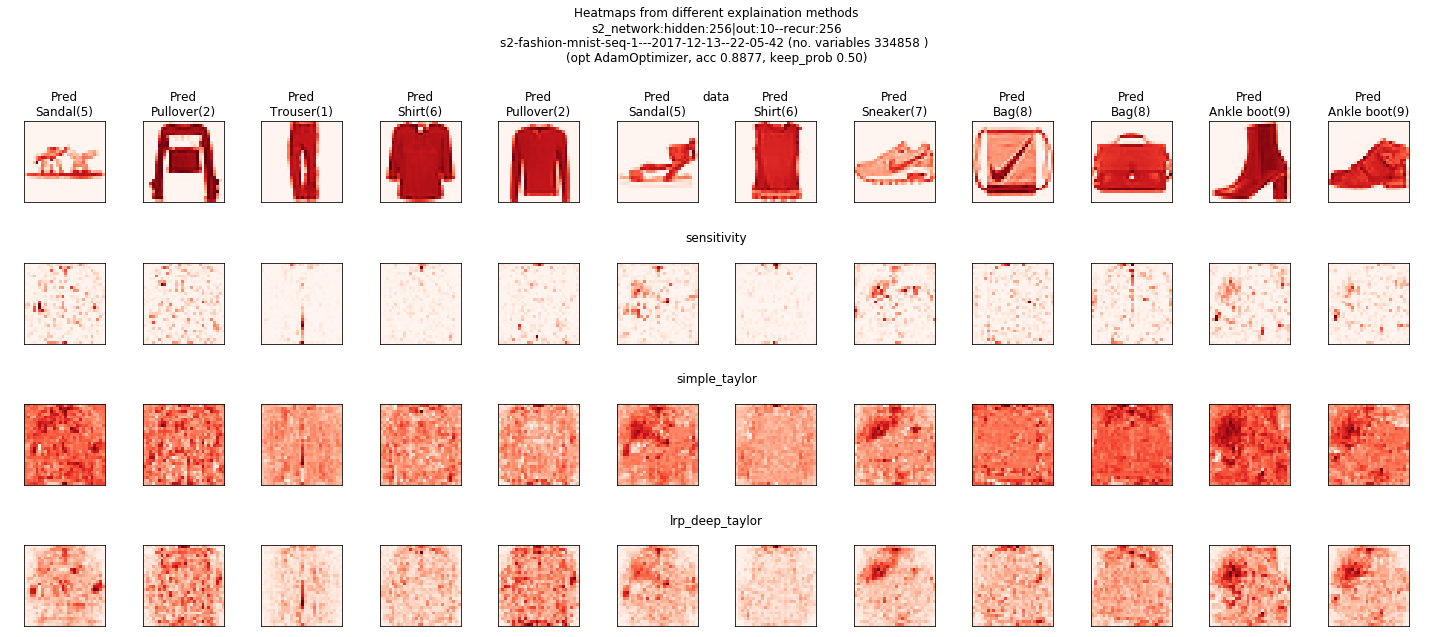

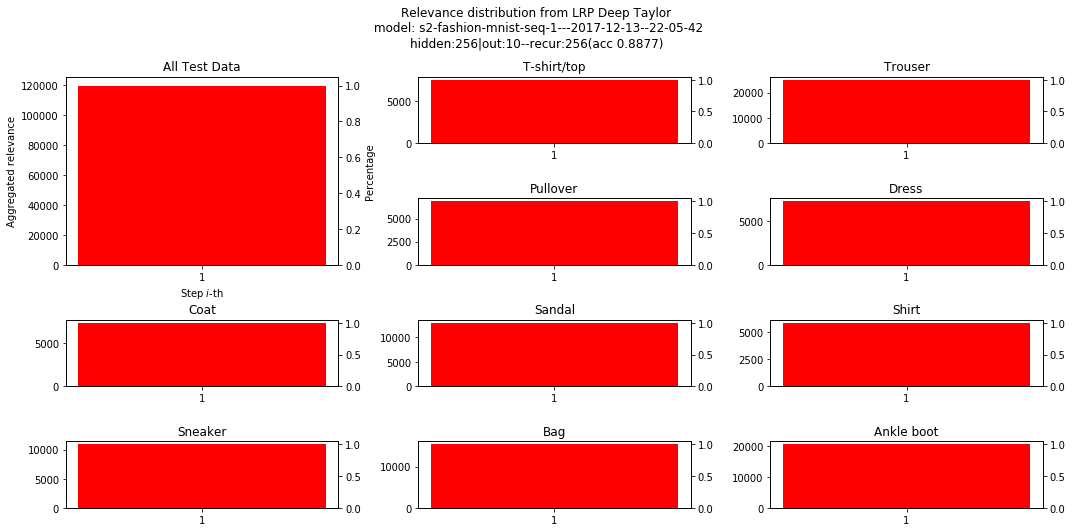

In [222]:
plot_rel_and_dist(fashion_mnist_models['seq-1']['s2'])

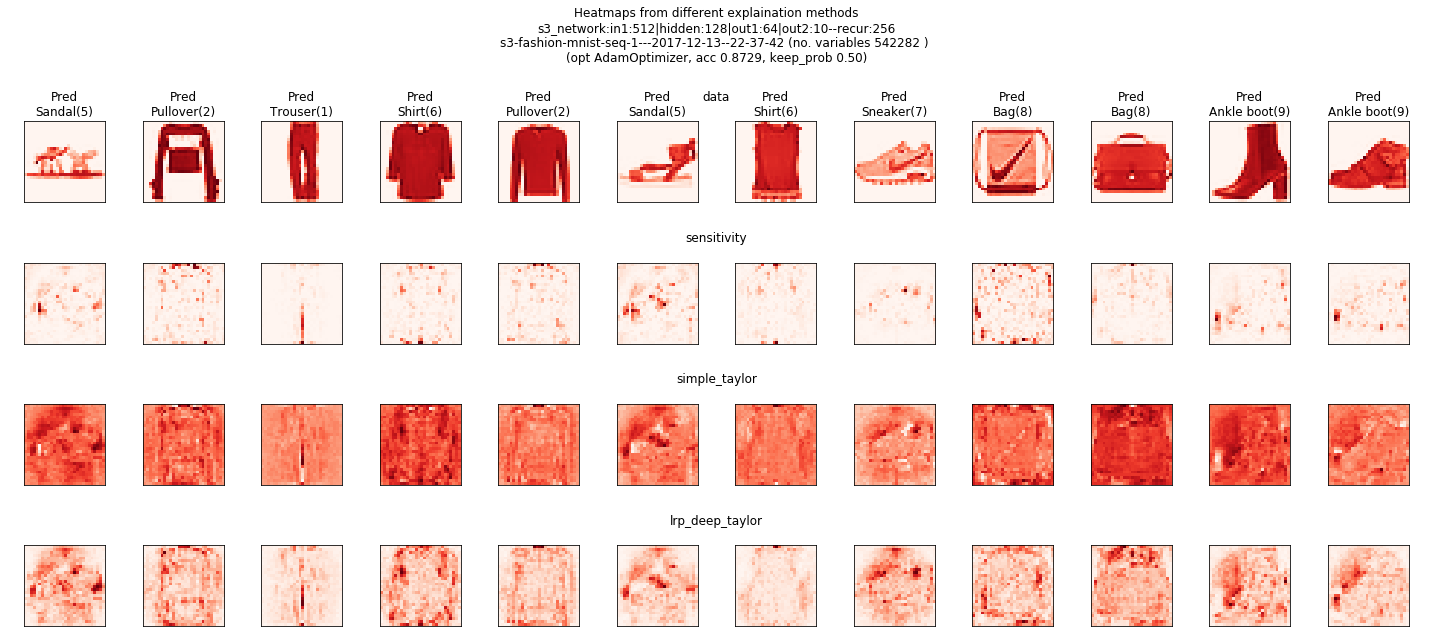

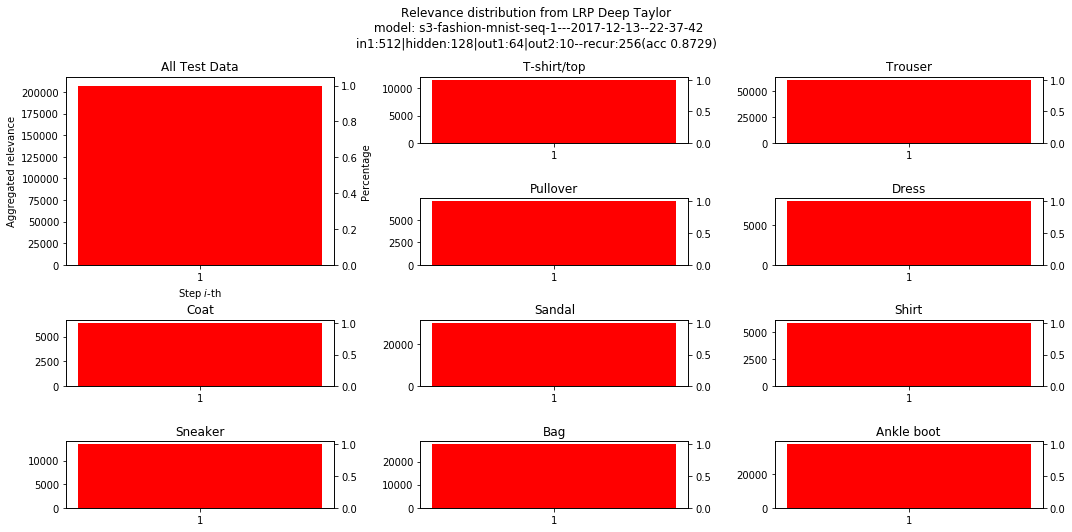

In [223]:
plot_rel_and_dist(fashion_mnist_models['seq-1']['s3'])

## Seq-4

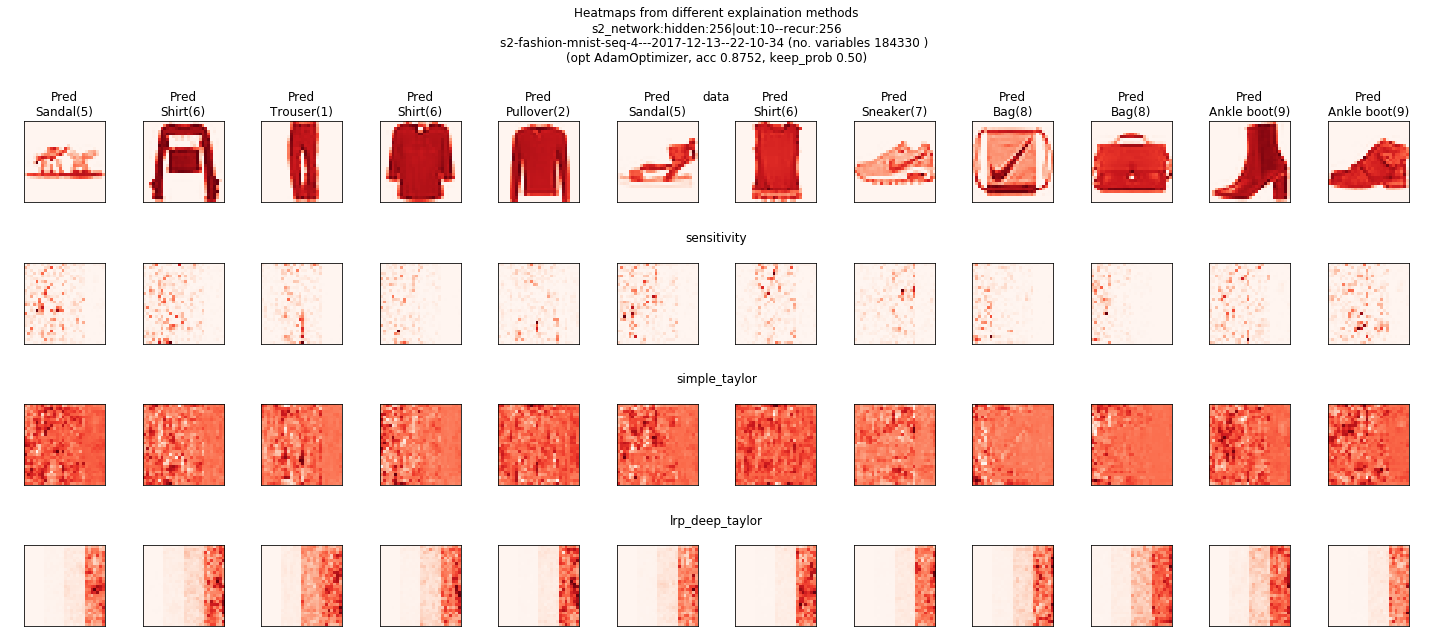

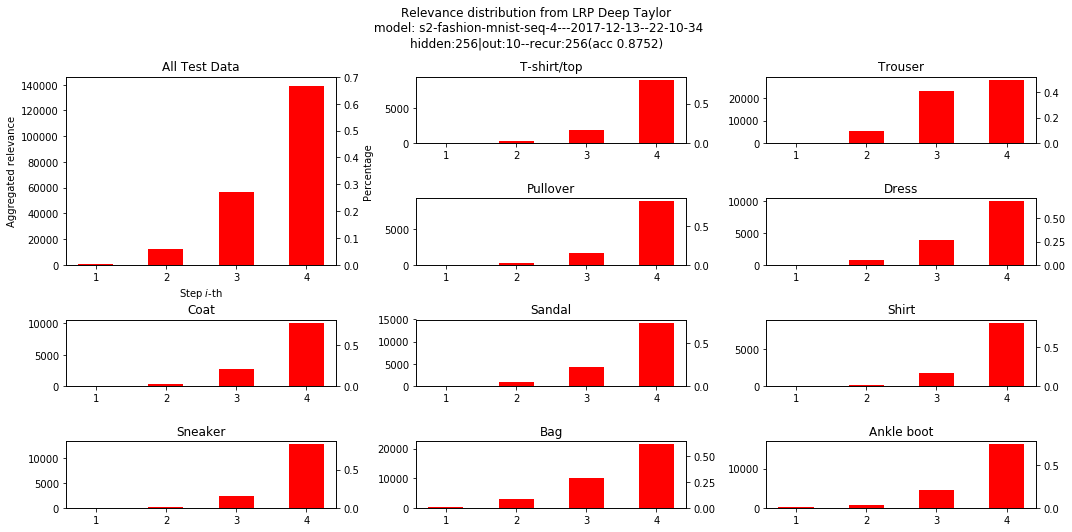

In [224]:
plot_rel_and_dist(fashion_mnist_models['seq-4']['s2'])

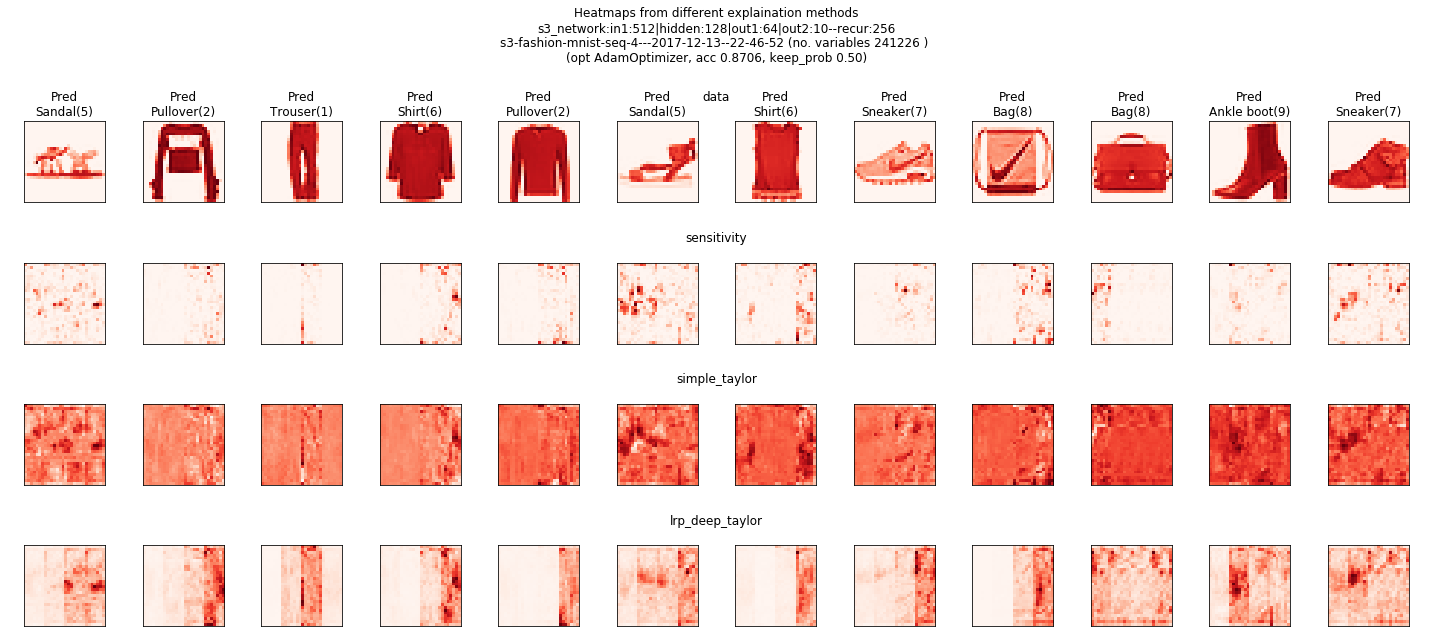

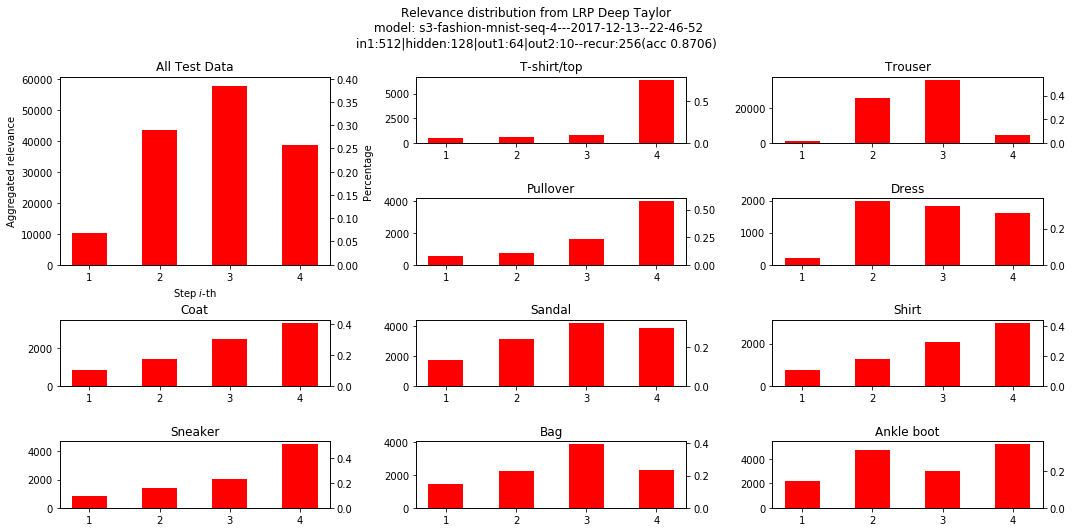

In [225]:
plot_rel_and_dist(fashion_mnist_models['seq-4']['s3'])

## Seq-7

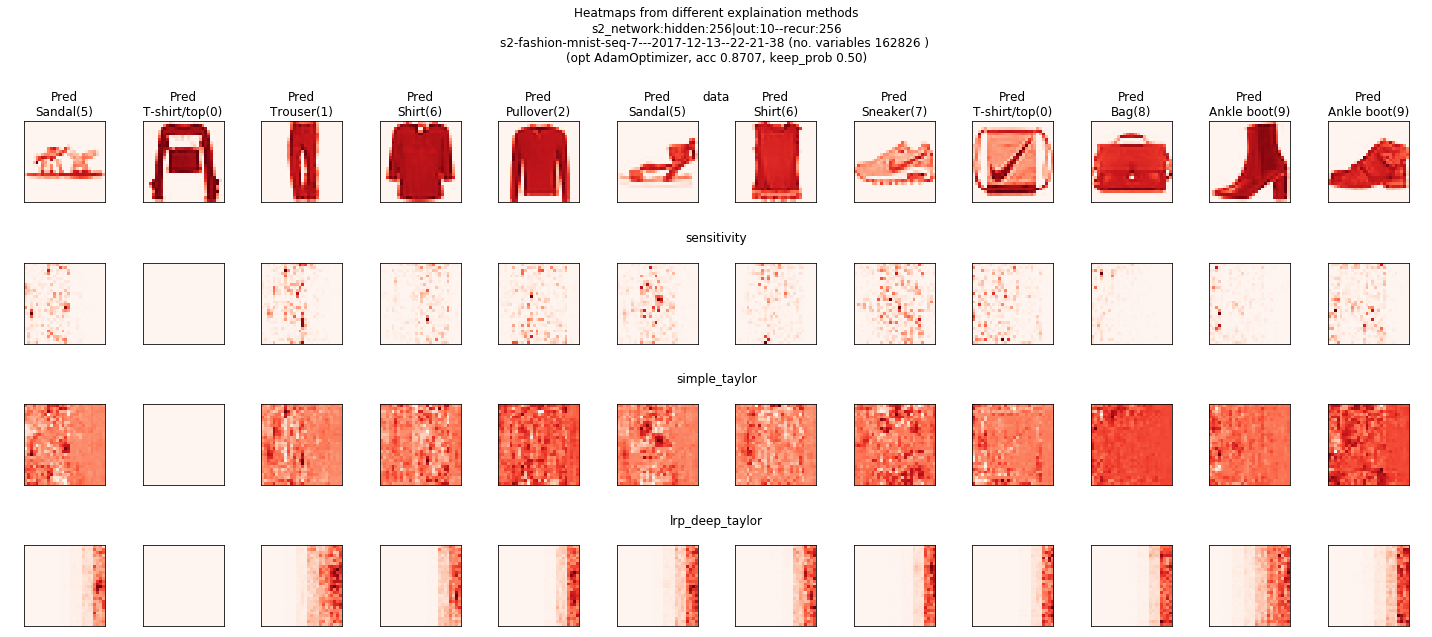

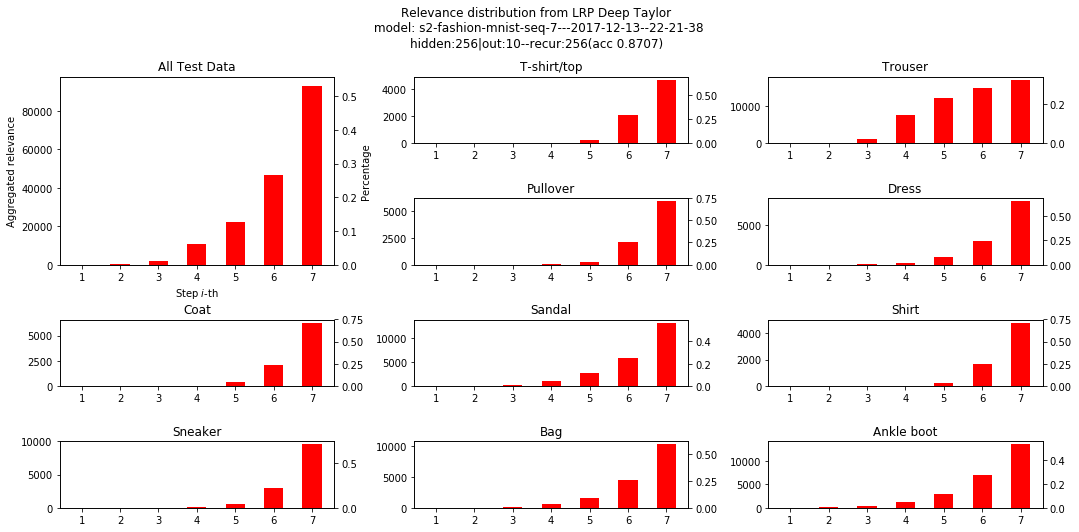

In [226]:
plot_rel_and_dist(fashion_mnist_models['seq-7']['s2'])

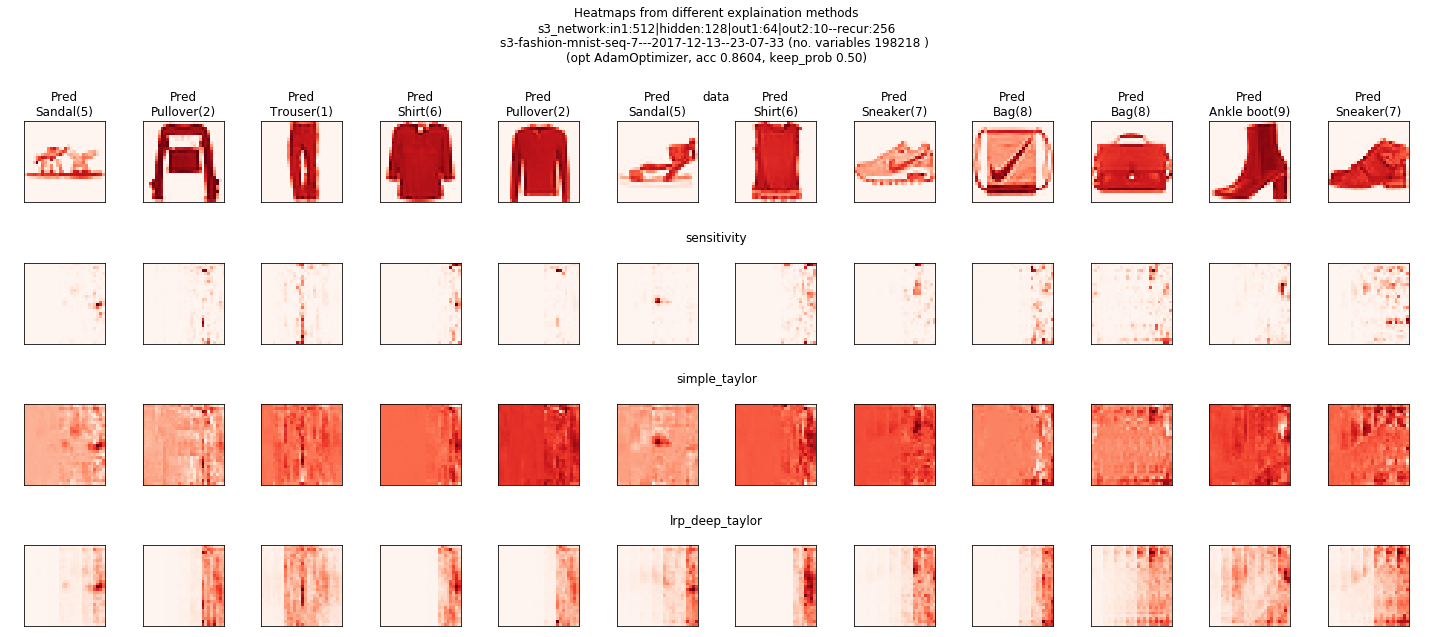

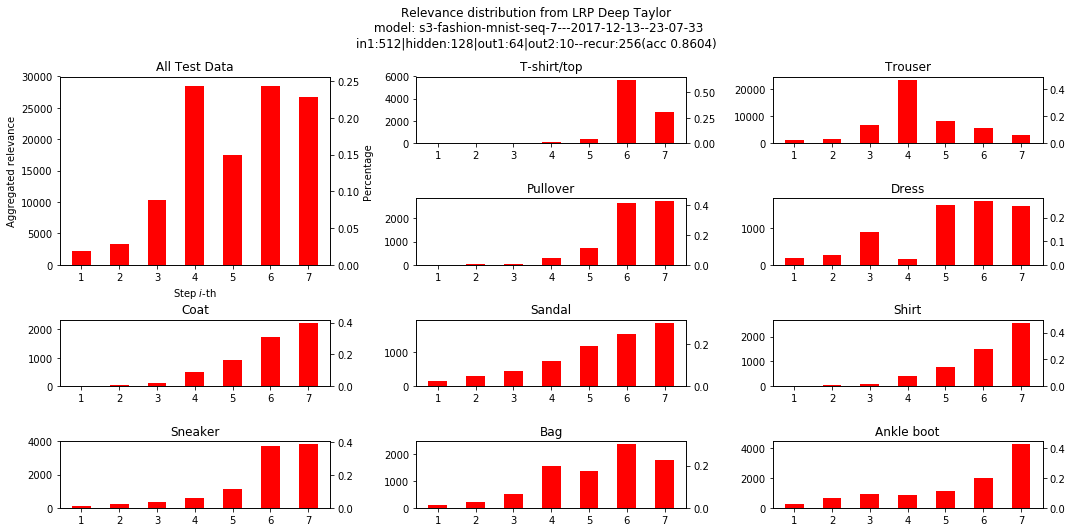

In [227]:
plot_rel_and_dist(fashion_mnist_models['seq-7']['s3'])

# Sprint 9

In [15]:
s9_models = {
    'seq-1': {
        'deep_4l': '../experiment-results/sprint-9/deep_4l_network-fashion-mnist-seq-1---2017-12-18--23-48-47',
    },
    'seq-7': {
        'deep_4l': '../experiment-results/sprint-9/deep_4l_network-fashion-mnist-seq-7---2017-12-19--00-20-03'
    }
}

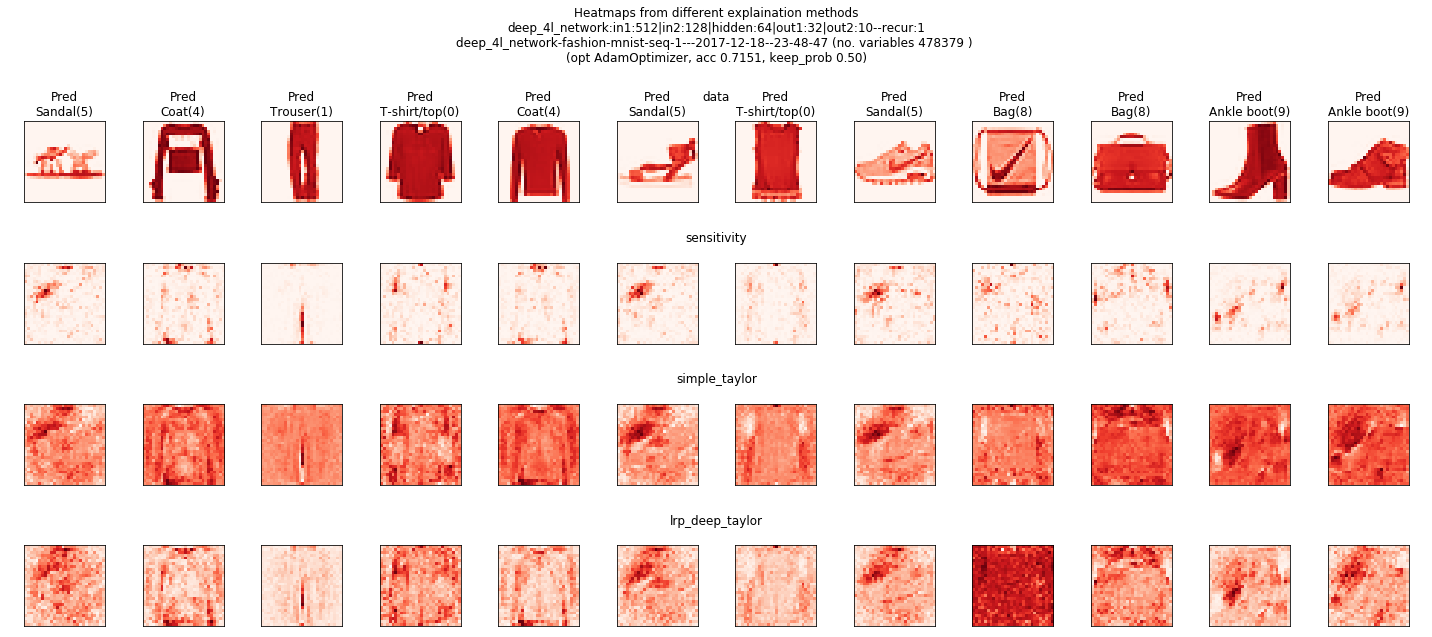

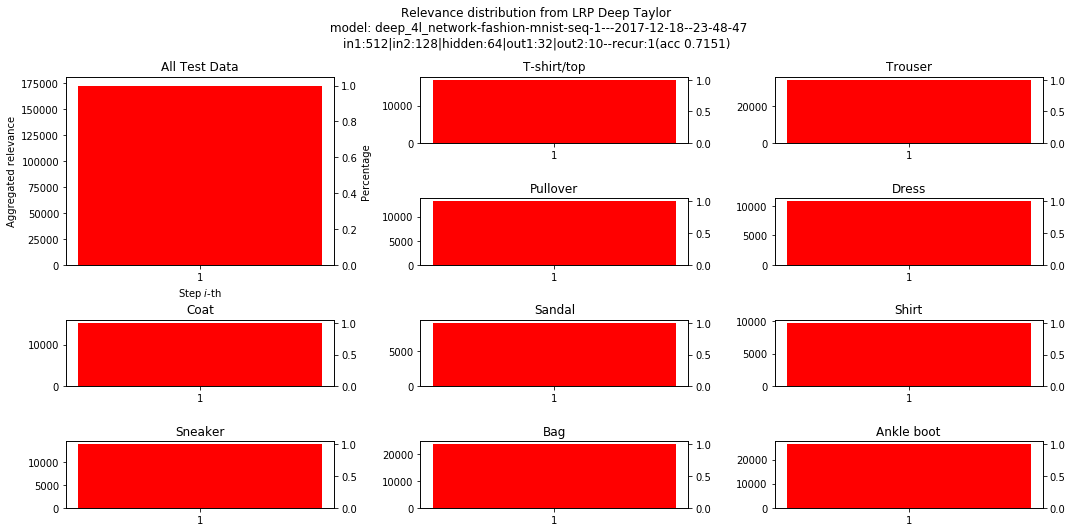

In [22]:
plot_rel_and_dist(s9_models['seq-1']['deep_4l'])

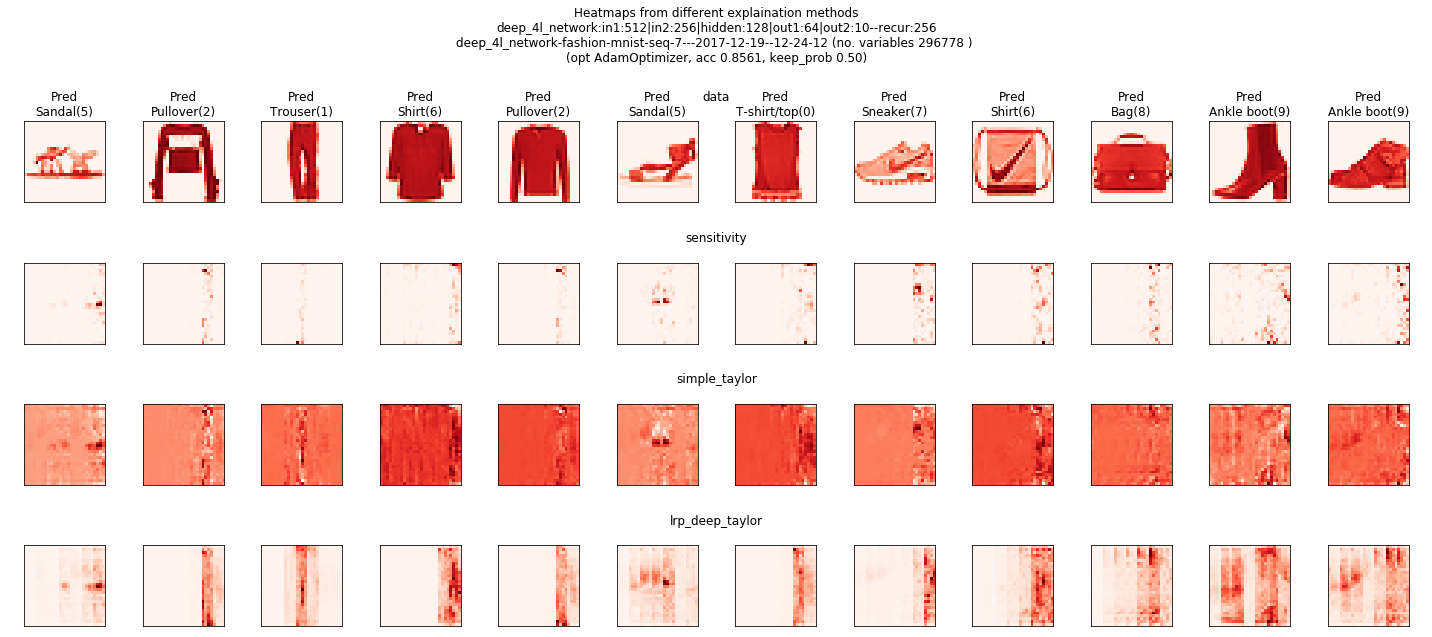

In [45]:
plot_rel_and_dist('../experiment-results/sprint-9/deep_4l_network-fashion-mnist-seq-7---2017-12-19--12-24-12')

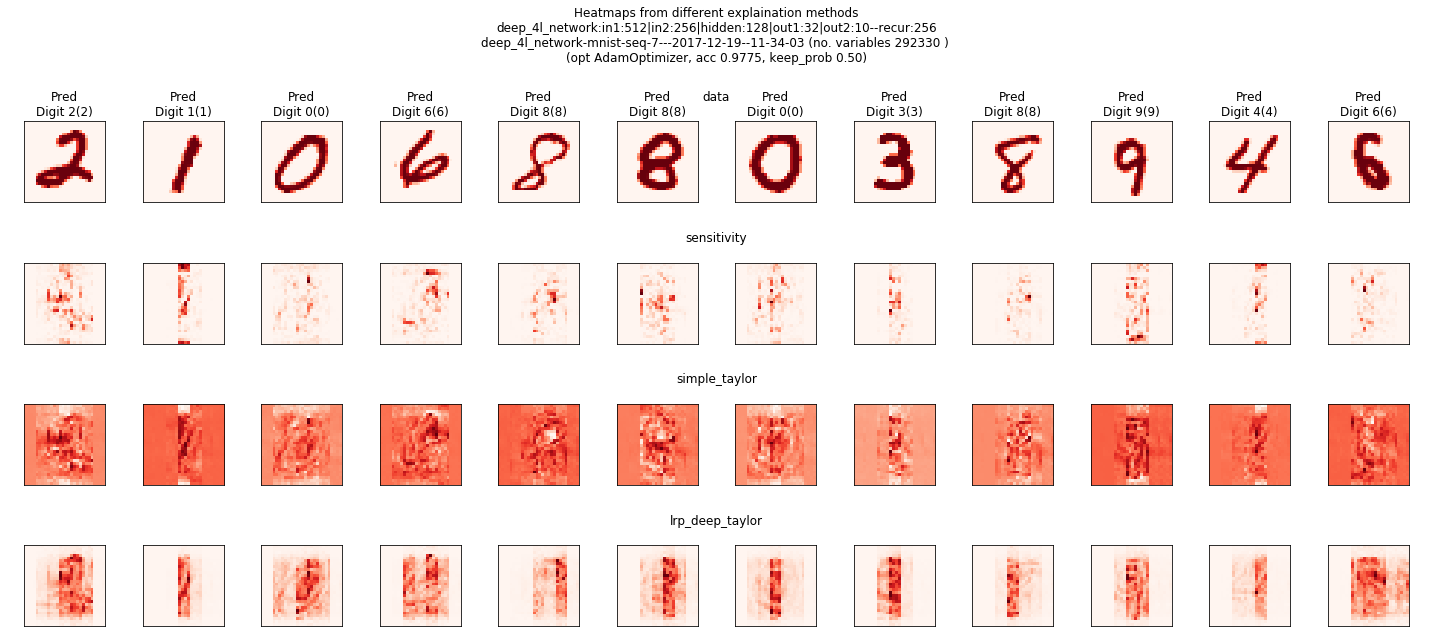

In [43]:
import imp
imp.reload(deep_4l_network)
plot_rel_and_dist('../experiment-results/sprint-9/deep_4l_network-mnist-seq-7---2017-12-19--11-34-03')

2017-12-20 00:55:12,669 | INFO : provider.py(load 14) - ExperimentArtifact(accuracy=0.8830999732017517, architecture='conv1:5x5x32=>2x2[2,2]|conv2:5x5x64=>2x2[2,2]|hidden:1024|out1:256|out2:10--recur:1', batch=50, column_at_a_time=28, dims=28, epoch=10, experiment_name='convdeep_4l_network-fashion-mnist-seq-1---2017-12-19--13-10-10', lr=0.0001, max_seq_length=28, seq_length=1, path='../experiment-results/sprint-9/convdeep_4l_network-fashion-mnist-seq-1---2017-12-19--13-10-10', architecture_name='convdeep_4l_network', val_accuracy=0.8955000042915344, keep_prob=0.5, optimizer='AdamOptimizer', dataset='fashion-mnist', regularizer=0.0)
2017-12-20 00:55:12,709 | INFO : convdeep_4l_network.py(__init__ 59) - Output dims after conv and pooling layers
2017-12-20 00:55:12,710 | INFO : convdeep_4l_network.py(__init__ 60) - (1, 7, 7, 64)
2017-12-20 00:55:13,428 | INFO : base.py(compute_grad_wrt_x 75) - Compute grad wrt. X shape (12, 28, 28)
2017-12-20 00:55:14,114 | INFO : base.py(compute_grad_wrt

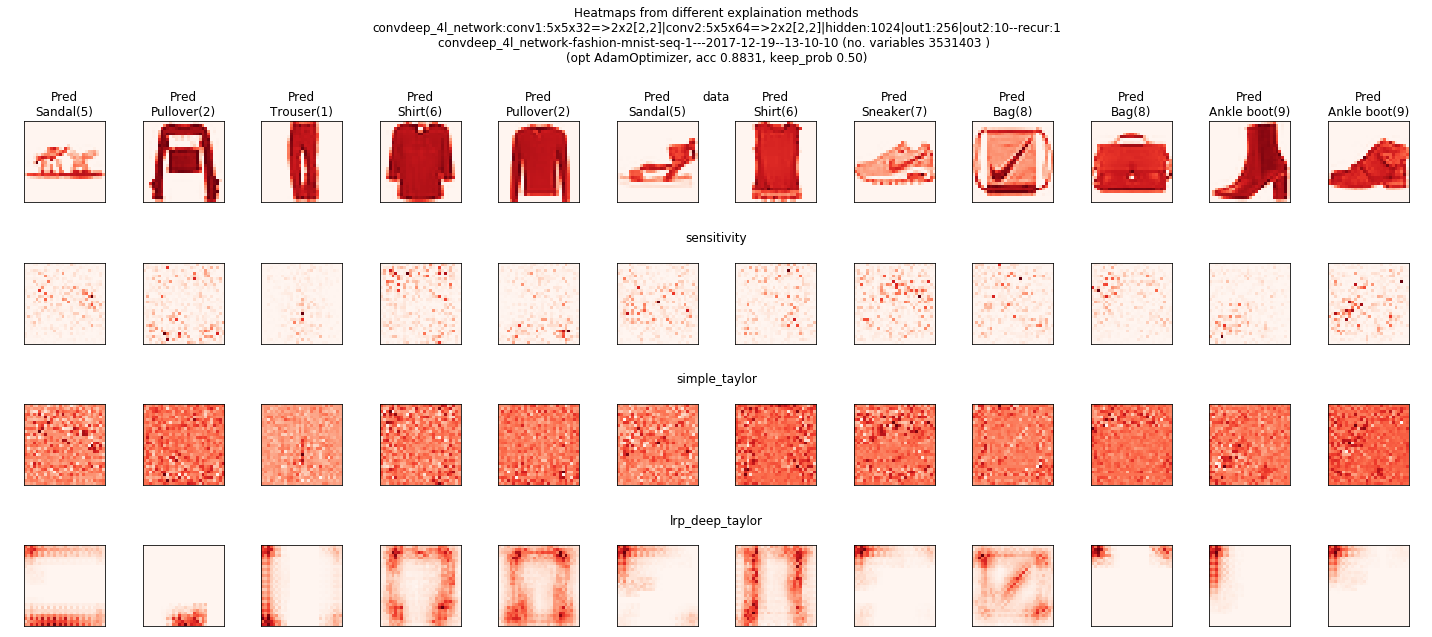

In [66]:
import imp
imp.reload(convdeep_4l_network)
from model.components import lrp, layer
from model import base
imp.reload(base)
imp.reload(lrp)
imp.reload(layer)
# conv1:5x5x32=>2x2[2,2]|conv2:5x5x64=>2x2[2,2]|hidden:1024|out1:256

plot_rel_and_dist('../experiment-results/sprint-9/convdeep_4l_network-fashion-mnist-seq-1---2017-12-19--13-10-10')


In [ ]:
plt.show()

In [97]:
[1] + list((2,3))

[1, 2, 3]